# Resnet18

resnetを使った学習  
resnetの１次元信号のための事前学習モデルがない？？？  
ここではresnet風のアーキテクチャを定義して学習してみる。

２次元用のresnetアーキテクチャを見てみる

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

In [6]:
# Pre-trained weightsを使う場合
resnet = models.resnet18(pretrained=False)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Resnet1dの定義

Resnet1d  
BasicBlock1dを定義すればいいのかも  
スキップ構造を導入しているところに注目  
->入力データの畳み込み層をまたいで出力に加算するような構造のよう  

In [16]:
class BasicBlock1d(nn.Module):
    expansion = 1

    def __init__(
            self, 
            in_planes, 
            planes, 
            
            stride=1):
        
        super(BasicBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = None
        # 以下はスキップ接続のための入力xのリサンプリング
        if stride != 1 or in_planes != self.expansion*planes:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        skipX = x
        out = self.bn1(self.conv1(x)) 
        out = self.relu(out)# ここでreluまで通す
        out = self.bn2(self.conv2(out)) # ここでbn2まで通す

        if self.downsample is not None:
            skipX = self.downsample(x)

        out += skipX # ここでスキップ接続する。加算

        #out = F.relu(out)
        return out

class ResNet1d(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8):
        super(ResNet1d, self).__init__()
        self.in_planes = 64 # resnet18に合わせる

        self.conv1 = nn.Conv1d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool1d(3,2,1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # strideを２にするブロックがある場合はstride=2を指定する
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        #out = F.avg_pool1d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_1d():
    return ResNet1d(BasicBlock1d, [2, 2, 2, 2])


In [17]:
# モデルのインスタンスを作成
model = ResNet18_1d()
print(model)


ResNet1d(
  (conv1): Conv1d(3, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1

以上でresnet1dの定義終わり。  
以下はデータローダやデータの用意をするやつ

# データ用意

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [19]:
fold = "../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz.npy")
#gyr_xyz = np.load(f"{fold}gyr_xyz.npy")
#mag_xyz = np.load(f"{fold}mag_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
#xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
print(acc_xyz.shape)
#print(gyr_xyz.shape)
#print(mag_xyz.shape)
#print(xyz.shape)
print(label.shape)

(196072, 3, 500)
(196072,)


In [20]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = acc_xyz.reshape(-1, acc_xyz.shape[-1])  # (196072*3, 500)

scaled_xyz = scaler.fit_transform(xyz_reshaped)  # 標準化

scaled_xyz = scaled_xyz.reshape(acc_xyz.shape)  # 元の形に戻す

print(scaled_xyz.shape)  # (196072, 3, 500)


(196072, 3, 500)


In [21]:
#おしり3万データを使う  
xyz = scaled_xyz[-40000:-10000,:]
label = label[-40000:-10000]
print(xyz.shape)
print(label.shape)

(30000, 3, 500)
(30000,)


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(xyz, label, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
# train_randomの生成
#train_xyz_random = train_xyz
#train_label_random = train_label

Train data shape: (24000, 3, 500)
Test data shape: (6000, 3, 500)
Train label shape: (24000,)
Test label shape: (6000,)
1.0    4235
4.0    3917
7.0    3893
6.0    3582
2.0    3010
5.0    2964
8.0    1445
3.0     954
Name: count, dtype: int64
1.0    1041
7.0     964
4.0     960
6.0     926
5.0     774
2.0     719
8.0     373
3.0     243
Name: count, dtype: int64


In [24]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    
    #データセットをバッチサイズごとに分割
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')

        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch-1)
            yield X_batch, y_batch


def forward_by_batches(cnn, X):
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y-1.0).type(torch.int64).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

In [39]:
lr = 1e-4
resnet = ResNet18_1d().to(device)
print(resnet) # ここではcnnのネットワーク構造の定義をして、そのネットワークの構造をprintしている。

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー損失を使用してモデルの出力と実際のラベルとの差を計算するためのインスタンス定義
optimizer = optim.Adam(resnet.parameters(), lr=lr,weight_decay=1e-3) # オプティマイザーを使用し、設定された学習率lrでモデルのパラメータを最適化する。Adamはよく使われるやつでパフォーマンスが高いらしい　
# optim.Adam()ではcnnのパラメータへの直接参照をすることができるnum_filters
# 学習率スケジューラの定義
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

ResNet1d(
  (conv1): Conv1d(3, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1

In [40]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 50
batch_size = 600  # size of the mini-batch　バッチサイズを64にしている 64が今のところ最高評価
count = 0
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    if False:#i!=0:
        if loss.item() < 0.3 and count==0:
            batch_size = 2048
            count += 1
            print(f"batch_size:{batch_size}, count:{count}")
        if count!=0:
            count +=1
        if count == 25:
            batch_size = batch_size*2
            #count+=1
            print(f"batch_size:{batch_size}, count:{count}")
        if count == 50:
            print("break!")
            break
        

    dataloader = create_dataloader(train_xyz, train_label, int(batch_size), shuffle=True)
    

    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device) # ここでdeviceにデータを移行
        resnet.zero_grad()
        output = resnet(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    #scheduler.step()  # エポックの終わりに学習率を調整

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(resnet, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
     # エポックごとの損失や精度を記録
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}, test Loss:{results['loss']}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 0.9054028391838074, test Loss:0.9657143354415894
Epoch 2/50, Loss: 0.7624790668487549, test Loss:0.7982747554779053
Epoch 3/50, Loss: 0.7485539317131042, test Loss:0.7133777141571045
Epoch 4/50, Loss: 0.7485374808311462, test Loss:0.679556667804718
Epoch 5/50, Loss: 0.6548703908920288, test Loss:0.6727139949798584
Epoch 6/50, Loss: 0.6021150946617126, test Loss:0.6213865280151367
Epoch 7/50, Loss: 0.6187593340873718, test Loss:0.6198093891143799
Epoch 8/50, Loss: 0.6129482984542847, test Loss:0.5901710987091064
Epoch 9/50, Loss: 0.5332270264625549, test Loss:0.5798868536949158
Epoch 10/50, Loss: 0.5314844250679016, test Loss:0.5772585868835449
Epoch 11/50, Loss: 0.6855124235153198, test Loss:0.5610755681991577
Epoch 12/50, Loss: 0.5272960066795349, test Loss:0.5317661762237549
Epoch 13/50, Loss: 0.5013308525085449, test Loss:0.5259453058242798
Epoch 14/50, Loss: 0.48364976048469543, test Loss:0.509385347366333
Epoch 15/50, Loss: 0.4707738757133484, test Loss:0.5057023


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.80      0.78      0.79      1041
         2.0       0.96      0.94      0.95       719
         3.0       1.00      0.99      0.99       243
         4.0       0.97      0.97      0.97       960
         5.0       0.90      0.89      0.89       774
         6.0       0.96      0.78      0.86       926
         7.0       0.81      0.77      0.79       964
         8.0       0.45      0.77      0.57       373

    accuracy                           0.85      6000
   macro avg       0.86      0.86      0.85      6000
weighted avg       0.87      0.85      0.86      6000



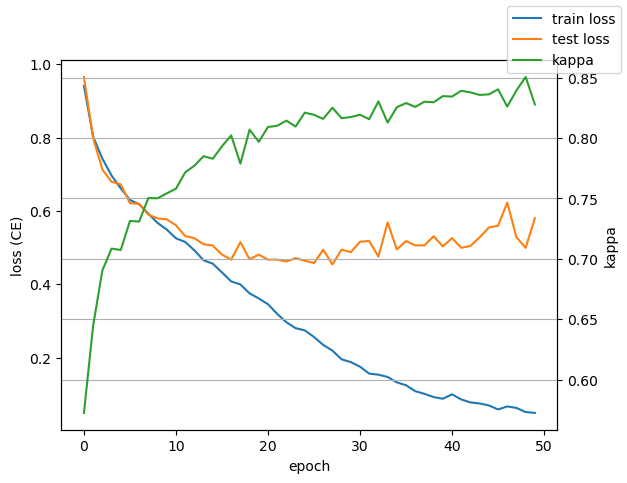

In [41]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

問題点はかなり過学習をしてしまうこと  
基本的なresnetの定義はできたと思うので次のファイルで過学習を抑える方法について考えることにする